In [71]:
import numpy as np
import scipy.stats as stats
# import math
import gpflow
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, Exponentiation,RationalQuadratic, WhiteKernel
import random

In [72]:
def generate_fake_data(xmin, xmax, n_samples, polynomial_degree, noise_level):
    x = [random.uniform(xmin, xmax) for _ in range(n_samples)]
    # Generate random noise of the same length as x
    noise = np.random.normal(scale=noise_level, size=n_samples)
    # Generate the y values according to a polynomial equation with some added noise
    y = np.polyval(np.random.randn(polynomial_degree + 1), x) + noise
    return np.array(x), np.array(y)

In [73]:
x,y = generate_fake_data(0, 1, 10, 2, 0.1)

### Step 1: GP Fit

In [74]:
def GPR(X, Y, kernel= None):
    """
    Fit GP to demand
    run once per product

    :param X: X values with shape (-1, 1)
    :param Y: Y values with shape (-1, 1)
    :param kernel: kernel for the GP
    :return: GPR model
    """

    kernel = kernel
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gaussian_process.fit(X, Y)
    return gaussian_process

model = GPR(x.reshape(-1,1),y.reshape(-1,1), kernel = 1 * RationalQuadratic(alpha= 10, length_scale=100) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e2)))
print(model)

GaussianProcessRegressor(kernel=1**2 * RationalQuadratic(alpha=10, length_scale=100) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)


### Test Step 1

In [75]:
### Plot model to check
Xplot = np.linspace(-0.1, 1.1, 100)
f_mean, f_var = model.predict(Xplot.reshape(-1,1), return_std=True)

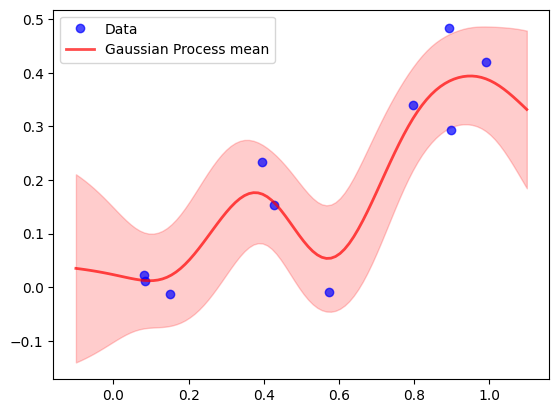

In [76]:
plt.plot(x, y, 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, f_mean, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, f_mean - f_var, f_mean + f_var, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend(); plt.show();

### Step 2 : Sample demand from GP

We are still assuming 1 product here to make things simpler